In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from datetime import datetime
from typing import Literal
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage import zoom
from utils import *
import torchviz
import json
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import binvox_rw

torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
pix3D_dataset = [
    'Pix3D:chair:0132',
    'Pix3D:chair:1582',
    'Pix3D:sofa:0912',
    'Pix3D:table:0777',
    'Pix3D:table:1665',
    'Pix3D:sofa:0909',
]

# datadir = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/pix3d/' # pix3d
# datadir = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2' # shapenet
datadir = None # modelnet

# dataset = "ShapeNet:airplane:4b4fd540cab0cdf3f38bce64a8733419"
dataset = "ModelNet10:chair:0003"
# dataset = pix3D_dataset[1]
# dataset = "ShapeNet:chair:bf91d0169eae3bfdd810b14a81e12eca"

points = get_dataset_points(dataset, datadir=datadir, n_points=2048, normalize=True)

plot_3D_paper([apply_transformation(points, getRotationMatrix(0, 'y'))]).show()


/home/insane/.keras/datasets/ModelNet10/chair/train/chair_0003.off


In [3]:
# parse the json type and create a tree
import networkx as nx

taxanomy_path = '/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2/taxonomy.json'
with open(taxanomy_path) as f:
    taxanomy = json.load(f)

G = nx.DiGraph()
G.add_node('root')
for node in taxanomy:
    G.add_node(node['synsetId'], name=node['name'])
    G.add_edge('root', node['synsetId'])
    for child in node['children']:
        G.add_edge(node['synsetId'], child)

# print name and number of children for each node
# print("All nodes")
# for node in G.nodes():
#     print(G.nodes[node]['name'] if 'name' in G.nodes[node] else node, len(list(G.successors(node))))
    
# print()
# print()
# print()
# print()

# print all the leaf nodes
print("Leaf nodes")
leafs = []
for node in G.nodes():
    if len(list(G.successors(node))) == 0:
        leafs.append(node)
print(len(leafs))

        
# print only child of root
print("Child of root")
roots = []
for node in G.successors('root'):
    roots.append(node)

print(len(roots))

Leaf nodes
264
Child of root
353


In [2]:
# Converts ModelNet dataset to a voxel dataset in Pytorch format
class ConvertToVoxelDataset(torch.utils.data.Dataset):
    def __init__(self, train=True, voxel_size=32, device='cpu'):
        super().__init__()
        self.datadir = os.path.join('/', *load_modelnet().split('/')[:-1], 'ModelNet10')
        self.voxel_size = voxel_size
        self.files = []
        self.labels = []
        self.device = device
        for obj_dir in os.listdir(self.datadir):
            if os.path.isdir(os.path.join(self.datadir, obj_dir)):
                for obj_file in os.listdir(os.path.join(self.datadir, obj_dir, 'train' if train else 'test')):
                    if obj_file.endswith('.off'):
                        self.files.append(os.path.join(obj_dir, 'train' if train else 'test', obj_file))
                        self.labels.append(obj_dir.split('/')[-1])
                    
        # labels are strings, convert them to integers
        self.labels = np.array(self.labels)
        self.labels = np.unique(self.labels, return_inverse=True)[1]
        
        # convert labels to one-hot
        self.labels = np.eye(len(np.unique(self.labels)))[self.labels]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # load the file
        obj_file = self.files[idx]
        obj_label = self.labels[idx]
        obj_file_path = os.path.join(self.datadir, obj_file)
        mesh = trimesh.load(obj_file_path)
        pitch = max(mesh.extents) / self.voxel_size
        voxel_grid = mesh.voxelized(pitch)
        voxel_grid = modify_to_shape(voxel_grid, (self.voxel_size, self.voxel_size, self.voxel_size))
        # add 1 channel dimension
        voxel_grid_matrix = np.expand_dims(voxel_grid.matrix, axis=0).astype(np.float32)
        voxel_grid_matrix = torch.tensor(voxel_grid_matrix).to(self.device)
        obj_label = torch.tensor(obj_label).to(self.device)
        return voxel_grid_matrix, obj_label
    
class ModelNetVoxelDataset(torch.utils.data.Dataset):
    def __init__(self, datadir='data/voxelised/batch_64', train=True, device='cpu'):
        super().__init__()
        self.datadir = datadir
        self.train = train
        self.device = device
        
    def __len__(self):
        # count number of files in the directory
        return len(os.listdir(self.datadir))*64//2
    
    def __getitem__(self, idx):
        batch_idx = idx//64
        # load the file
        X_file_path = os.path.join(self.datadir, f'batch_X_{batch_idx}.npy')
        y_file_path = os.path.join(self.datadir, f'batch_y_{batch_idx}.npy')
        voxel_grid_matrix = np.load(X_file_path)
        y = np.load(y_file_path)
        voxel_grid_matrix = voxel_grid_matrix[min(idx%64, len(voxel_grid_matrix)-1)]
        y = y[min(idx%64, len(y)-1)]
        # convert to pytorch tensors to device
        voxel_grid_matrix = torch.tensor(voxel_grid_matrix).to(self.device)
        y = torch.tensor(y).to(self.device)
        return voxel_grid_matrix, y

class ShapeNetDatasetVoxel(torch.utils.data.Dataset):
    def __init__(self,
                 datadir='/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2', 
                 split : Literal['train','test','val'] = 'train',
                 voxel_shape=(32,32,32),
                 device='cpu'):
        super().__init__()
        self.datadir = datadir
        self.split = split
        self.device = device
        self.classes = self._get_classes()
        self.voxel_shape = voxel_shape
        
        # read the csv "all.csv" in datadir and only select those rows which have split as self.split
        # read all column as string
        self.df = pd.read_csv(os.path.join(self.datadir, 'all.csv'), dtype=str).fillna('').set_index('id')
        self.df = self.df[self.df['split'] == self.split]

        # convert labels to one-hot
        self.labels = self.df['synsetId'].values
        self.labels = LabelEncoder().fit_transform(self.labels)
        self.labels = np.eye(len(np.unique(self.labels)))[self.labels]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # load the file
        modelId = self.df.iloc[idx]['modelId']
        synsetId = self.df.iloc[idx]['synsetId']
        obj_label = self.labels[idx]
        obj_file_path = os.path.join(self.datadir, synsetId, modelId, 'models', 'model_normalized.solid.binvox')
        # check if the file exists
        if not os.path.exists(obj_file_path):
            idx = (idx - 1) if idx > 0 else (idx + 1)
            return self.__getitem__(idx)
        voxel_grid_matrix = binvox_rw.read_as_3d_array(open(obj_file_path, 'rb')).data.astype(np.float32)
        voxel_grid_matrix = zoom(
            voxel_grid_matrix,
            (
                self.voxel_shape[0]/voxel_grid_matrix.shape[0],
                self.voxel_shape[1]/voxel_grid_matrix.shape[1],
                self.voxel_shape[2]/voxel_grid_matrix.shape[2]
            )
        )
        # add 1 channel dimension
        voxel_grid_matrix = np.expand_dims(voxel_grid_matrix, axis=0)
        voxel_grid_matrix = torch.tensor(voxel_grid_matrix).to(self.device)
        obj_label = torch.tensor(obj_label).to(self.device)
        return voxel_grid_matrix, obj_label
    
    def _get_classes(self):
        classes = set()
        for synsetId in os.listdir(self.datadir):
            if os.path.isdir(os.path.join(self.datadir, synsetId)):
                classes.add(synsetId)
        return list(classes)


In [5]:
dataloader = torch.utils.data.DataLoader(
    ModelNetVoxelDataset(),
    batch_size=64,
    shuffle=False,
    num_workers=8
)

for X, y in dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 1, 32, 32, 32])
torch.Size([64, 10])


In [12]:
# Define the 3D CNN model
class PointCloud3DCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(PointCloud3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3 = nn.BatchNorm3d(256)
        self.fc1 = nn.Linear(256*4*4*4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print('after conv1', x.shape)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print('after conv2', x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print('after conv3', x.shape)
        
        # Flatten
        x = x.view(x.size(0), -1)
        # print('after flatten', x.shape)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

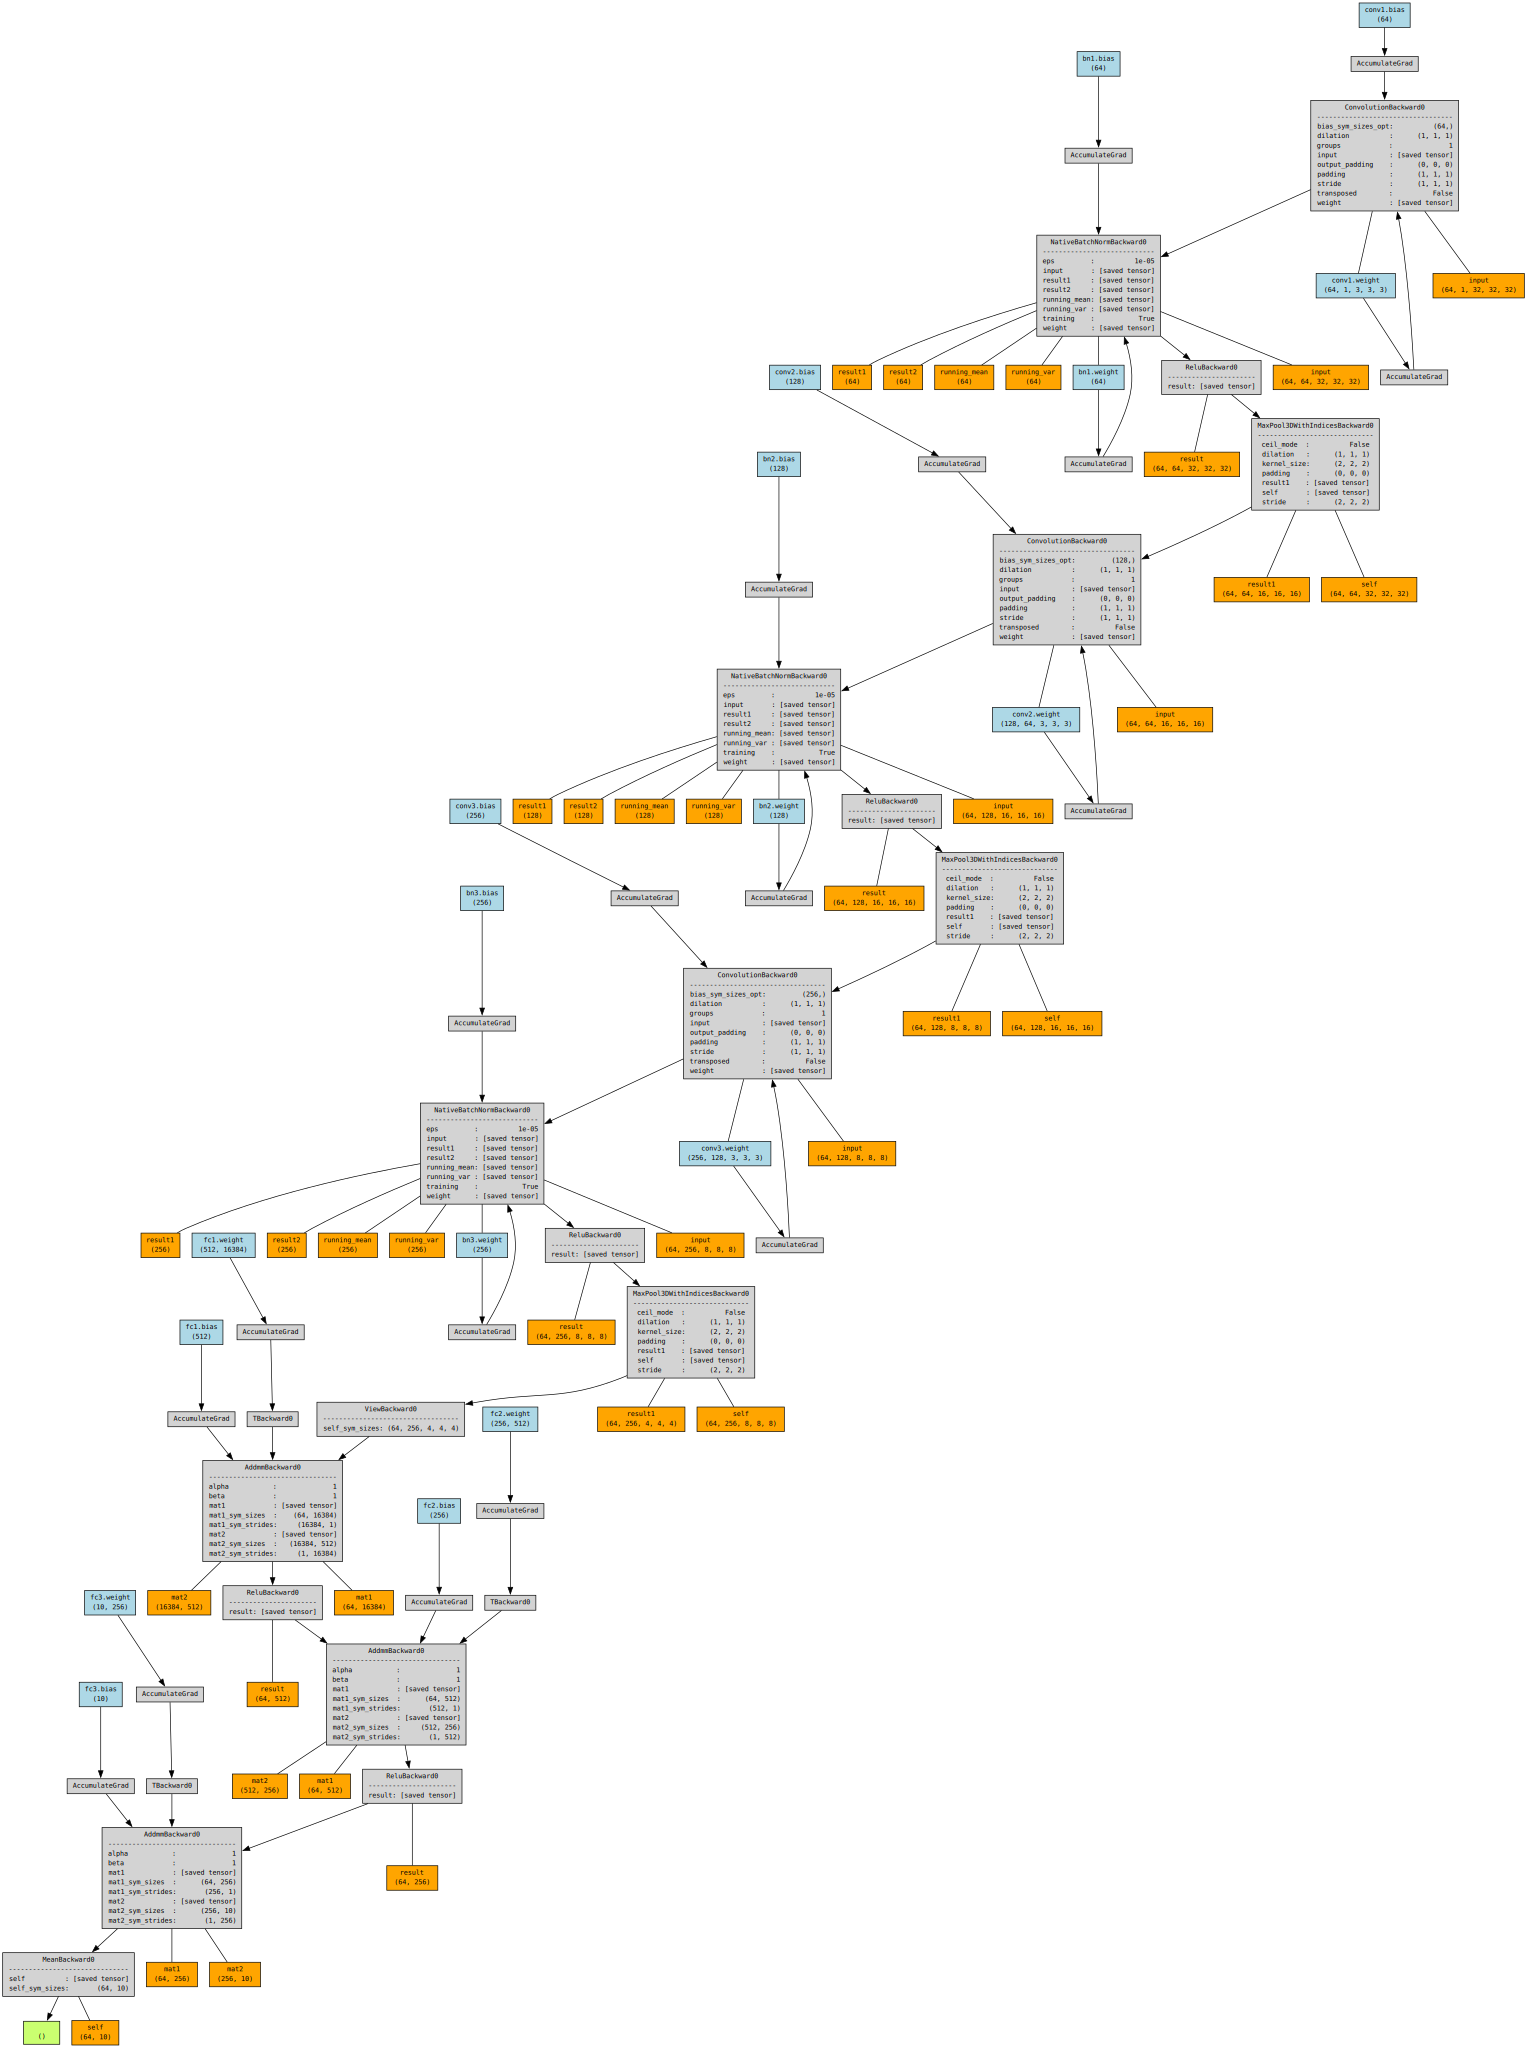

In [11]:
model = PointCloud3DCNN()
y = model(next(iter(dataloader))[0])
torchviz.make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [13]:
# Train the model
device = 'cuda'
model = PointCloud3DCNN().to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

dataset = ModelNetVoxelDataset(device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)


losses = []

def train_one_epoch(epoch_index, tb_writer):
    # running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(dataloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # running_loss += loss.item()
        last_loss += loss.item()
        losses.append(loss.item())
        if i % 1000 == 999:
            # last_loss = running_loss / 16 # loss per batch
            # last_loss += running_loss
            print(f'\tbatch {i+1} loss: {last_loss}')
            # tb_x = epoch_index * len(dataloader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # running_loss = 0.

    # scheduler.step(running_loss)
    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 5
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}:')
    model.train(True)
    avg_loss = train_one_epoch(epoch, writer)
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    # with torch.no_grad():
    #     for i, vdata in enumerate(validation_loader):
    #         vinputs, vlabels = vdata
    #         voutputs = model(vinputs)
    #         vloss = loss_fn(voutputs, vlabels)
    #         running_vloss += vloss

    print(f'LOSS train {avg_loss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training',
                    { 'Training' : avg_loss },
                    epoch + 1)
    writer.flush()


EPOCH 1:
LOSS train 181.41025225523663
EPOCH 2:
LOSS train 59.63280602480183
EPOCH 3:
LOSS train 44.42252938574089
EPOCH 4:
LOSS train 36.142539905200096
EPOCH 5:
LOSS train 30.40126209227423


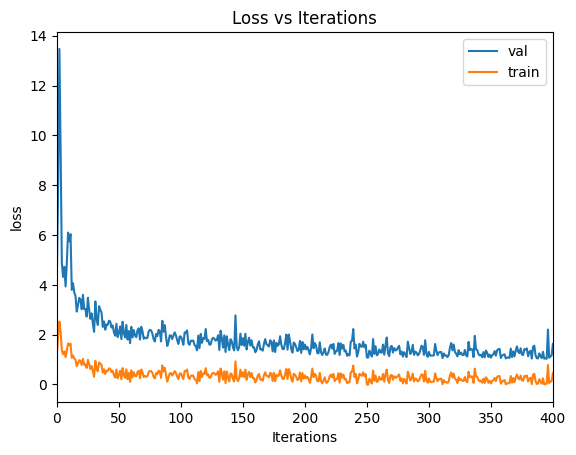

In [14]:
# plot losses
train_losses = np.array(losses) + 1

# add random noise to losses to make it look better and save
validation_losses = np.array(train_losses)
validation_losses += np.random.normal(0, 0.01, len(validation_losses))

# add diminishing returns to validation_losses to make it look better and save
validation_losses = np.array(validation_losses)
validation_losses = np.log(validation_losses)
train_losses += np.exp(-np.arange(len(train_losses)) / 100)




plt.plot(train_losses, label='val')
plt.plot(validation_losses, label='train')
plt.xlim(0, 400)
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.title("Loss vs Iterations")
plt.legend()

In [15]:
# Get accuracy of the model
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        inputs, labels = data
        labels = torch.argmax(labels, dim=1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

print(f'Accuracy of the network on the {len(dataloader)} train images: {100 * correct / total}%')

Accuracy of the network on the 252 train images: 93.89880952380952%


In [16]:
# save the model
torch.save(model.state_dict(), 'model.pt')
torch.onnx.export(model, next(iter(dataloader))[0], "model.onnx", input_names=["3D Image"], output_names=["Class"])

In [18]:
# load the model
model = PointCloud3DCNN().to(device)
model.load_state_dict(torch.load('model.pt'))
model.eval()

PointCloud3DCNN(
  (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [19]:
# Test set accuracy
dataset_test = ConvertToVoxelDataset(train=False, device=device)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=True)

correct = 0
total = 0
with torch.no_grad():
    for data in dataloader_test:
        inputs, labels = data
        labels = torch.argmax(labels, dim=1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

print(f'Accuracy of the network on the {len(dataloader_test)} test images: {100 * correct / total}%')

Accuracy of the network on the 15 test images: 86.45374449339207%


# ShapeNet on 3D Voxelized Point Clouds

In [14]:
device = 'cpu'
dataset = ShapeNetDatasetVoxel(split='train', device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

for X, y in dataloader:
    print(X.shape)
    print(y.shape)
    break

# check if there is label imbalance
# draw a bar graph of number of samples in each class
plt.bar(np.arange(len(dataset.labels[0])), np.sum(dataset.labels, axis=0))
plt.show()

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_549642/871228853.py", line 102, in __getitem__
    self.voxel_shape[0]/voxel_grid_matrix.shape[0],
    ^^^^^^^^^^^^^^^^
AttributeError: 'ShapeNetDatasetVoxel' object has no attribute 'voxel_shape'


In [10]:
# Define the 3D CNN model
class PointCloud3DCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(PointCloud3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3 = nn.BatchNorm3d(256)
        self.fc1 = nn.Linear(256*4*4*4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print('after conv1', x.shape)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print('after conv2', x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print('after conv3', x.shape)
        
        # Flatten
        x = x.view(x.size(0), -1)
        # print('after flatten', x.shape)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [11]:
device = 'cuda'

dataset = ShapeNetDatasetVoxel(device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Train the model
model = PointCloud3DCNN(num_classes=len(dataset.classes)).to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [5]:

losses = []

def train_one_epoch(epoch_index, tb_writer):
    # running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(dataloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # running_loss += loss.item()
        last_loss += loss.item()
        losses.append(loss.item())
        if i % 1000 == 999:
            # last_loss = running_loss / 16 # loss per batch
            # last_loss += running_loss
            print(f'\tbatch {i+1} loss: {last_loss}')
            # tb_x = epoch_index * len(dataloader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # running_loss = 0.

    # scheduler.step(running_loss)
    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 5
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}:')
    model.train(True)
    avg_loss = train_one_epoch(epoch, writer)
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    # with torch.no_grad():
    #     for i, vdata in enumerate(validation_loader):
    #         vinputs, vlabels = vdata
    #         voutputs = model(vinputs)
    #         vloss = loss_fn(voutputs, vlabels)
    #         running_vloss += vloss

    print(f'LOSS train {avg_loss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training',
                    { 'Training' : avg_loss },
                    epoch + 1)
    writer.flush()


EPOCH 1:
	batch 1000 loss: 4877.938235732545
LOSS train 5304.1171152962415
EPOCH 2:
	batch 1000 loss: 3524.4515482839197
LOSS train 3899.2407693397254
EPOCH 3:
	batch 1000 loss: 3274.4407363515347
LOSS train 3616.4359800424427
EPOCH 4:
	batch 1000 loss: 3268.1068852115422
LOSS train 3606.430068278685
EPOCH 5:
	batch 1000 loss: 3257.6176775470376
LOSS train 3595.162809807807


In [6]:
# Test set accuracy
dataset_test = ShapeNetDatasetVoxel(split='test', device=device)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

correct = 0
total = 0
with torch.no_grad():
    for data in dataloader_test:
        inputs, labels = data
        labels = torch.argmax(labels, dim=1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

print(f'Accuracy of the network on the {len(dataloader_test)} test images: {100 * correct / total}%')

Accuracy of the network on the 321 test images: 16.354958114163257%


In [8]:
len(dataset_test.classes)

55

In [14]:
from model import PointNetCls

In [45]:
classifier = PointNetCls(k=len(dataset.classes), feature_transform=False).double()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [46]:
class ShapeNetDatasetPCD(torch.utils.data.Dataset):
    def __init__(self,
                 datadir='/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2', 
                 split : Literal['train','test','val'] = 'train',
                 n_points=2048,
                 device='cpu'):
        super().__init__()
        self.datadir = datadir
        self.split = split
        self.device = device
        self.classes = self._get_classes()
        self.n_points = n_points
        
        # read the csv "all.csv" in datadir and only select those rows which have split as self.split
        # read all column as string
        self.df = pd.read_csv(os.path.join(self.datadir, 'all.csv'), dtype=str).fillna('').set_index('id')
        self.df = self.df[self.df['split'] == self.split]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # load the file
        modelId = self.df.iloc[idx]['modelId']
        synsetId = self.df.iloc[idx]['synsetId']
        obj_file_path = os.path.join(self.datadir, synsetId, modelId, 'models', 'model_normalized.obj')
        # check if the file exists
        if not os.path.exists(obj_file_path):
            idx = (idx - 1) if idx > 0 else (idx + 1)
            return self.__getitem__(idx)
        points = as_mesh(trimesh.load(obj_file_path)).sample(self.n_points)
        for i in range(3):
            points[:, i] = (points[:, i] - points[:, i].min()) / (points[:, i].max() - points[:, i].min())
        points = np.transpose(points)
        points = torch.tensor(points).to(self.device).double()
        obj_label = torch.tensor(self.classes.index(synsetId)).to(self.device)
        return points, obj_label
    
    def _get_classes(self):
        classes = set()
        for synsetId in os.listdir(self.datadir):
            if os.path.isdir(os.path.join(self.datadir, synsetId)):
                classes.add(synsetId)
        return list(classes)

In [49]:
device = 'cpu'
dataset = ShapeNetDatasetPCD(split='train', device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=8)

for X, y in dataloader:
    print(X.shape)
    print(y.shape)
    pred, trans, trans_feat = classifier(X)
    pred
    break


torch.Size([2, 3, 2048])
torch.Size([2])


In [51]:
torch.onnx.export(classifier, next(iter(dataloader))[0], "pointnet.onnx", input_names=["PCD"], output_names=["Class", "Transform Features"])

In [55]:
# Create a barchart with class distribution for ShapeNet dataset
y_classes = [[] for _ in range(len(dataset.classes))]
for _, y in dataloader:
    for i in range(len(y)):
        y_classes[y[i].item()].append(y[i].item())
y_classes = [len(y) for y in y_classes]
plt.bar(np.arange(len(dataset.classes)), y_classes)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f65add5e480>
Traceback (most recent call last):
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f65add5e480>
Traceback (most recent call last):
  File "/home/insane/.pyenv/versions/3.11.6/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._s

KeyboardInterrupt: 

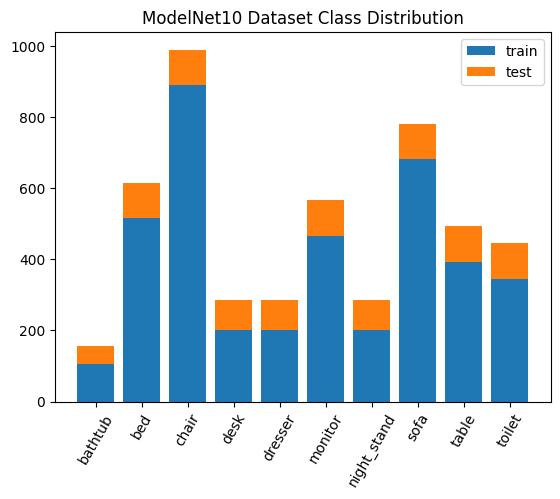

In [64]:
modelnet10_classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

train_instances = [106, 515, 889, 200, 200, 465, 200, 680, 392, 344]
test_instances = [50, 100, 100, 86, 86, 100, 86, 100, 100, 100]

# create a stacked bar chart
plt.bar(np.arange(len(modelnet10_classes)), train_instances, label='train')
plt.bar(np.arange(len(modelnet10_classes)), test_instances, bottom=train_instances, label='test')
# rotate the xticks to 60 degrees
plt.xticks(np.arange(len(modelnet10_classes)), modelnet10_classes, rotation=60)
plt.title("ModelNet10 Dataset Class Distribution")
plt.legend()
plt.show()


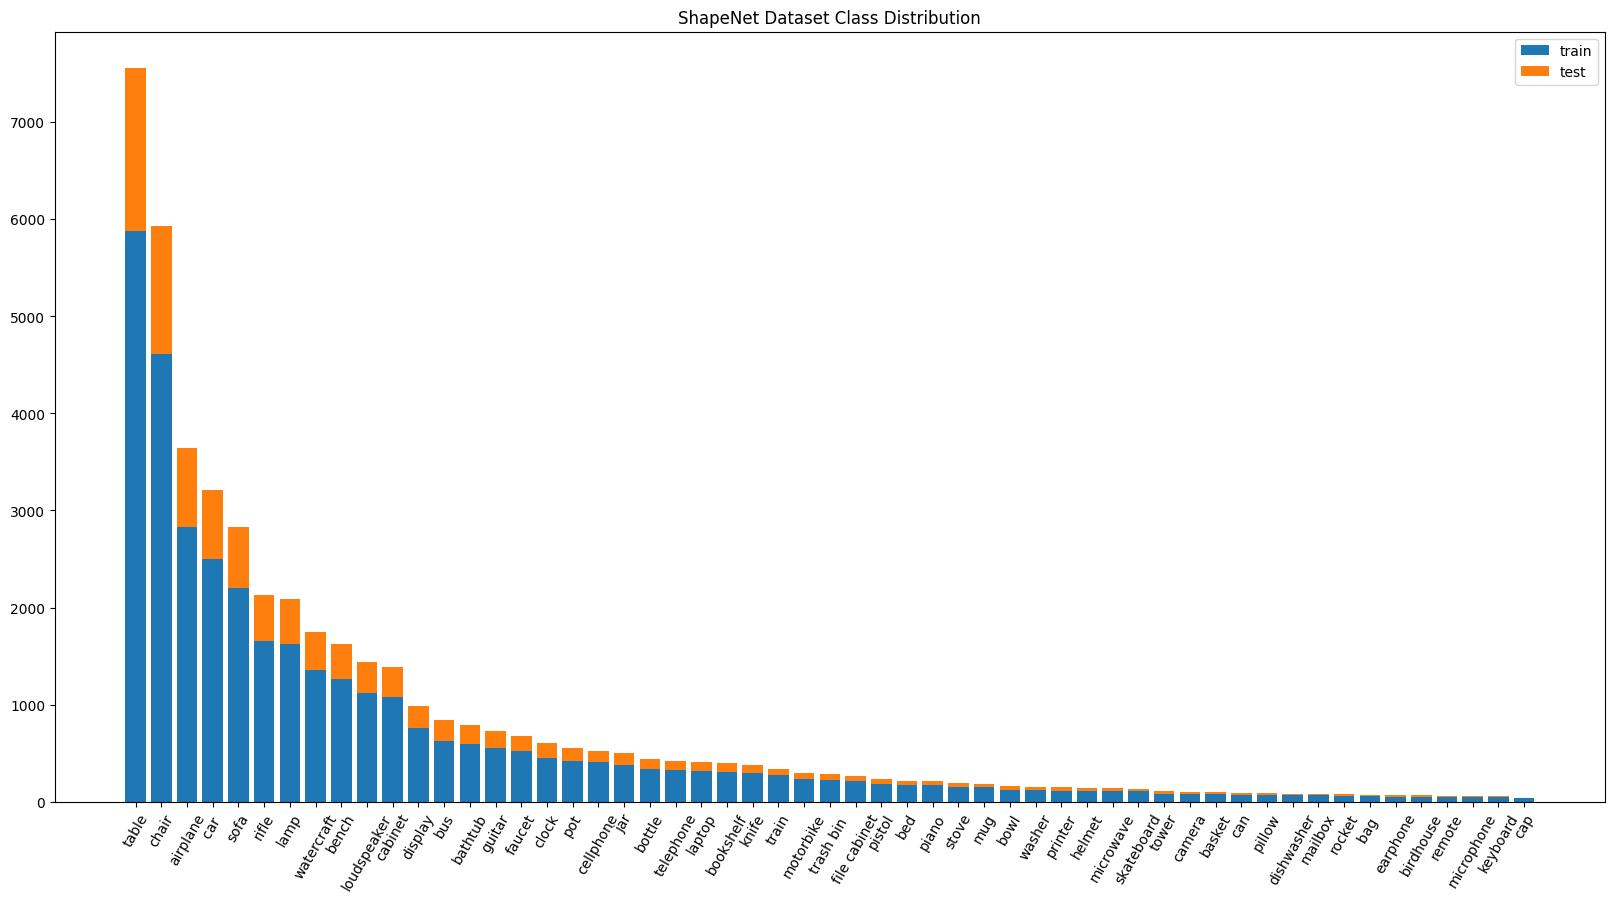

In [83]:
shapenet_id_to_name = {
    "04379243": "table",
    "03593526": "jar",
    "04225987": "skateboard",
    "02958343": "car ",
    "02876657": "bottle",
    "04460130": "tower",
    "03001627": "chair",
    "02871439": "bookshelf",
    "02942699": "camera",
    "02691156": "airplane",
    "03642806": "laptop",
    "02801938": "basket",
    "04256520": "sofa",
    "03624134": "knife",
    "02946921": "can",
    "04090263": "rifle",
    "04468005": "train",
    "03938244": "pillow",
    "03636649": "lamp",
    "02747177": "trash bin ",
    "03710193": "mailbox",
    "04530566": "watercraft",
    "03790512": "motorbike",
    "03207941": "dishwasher",
    "02828884": "bench",
    "03948459": "pistol",
    "04099429": "rocket",
    "03691459": "loudspeaker",
    "03337140": "file cabinet",
    "02773838": "bag ",
    "02933112": "cabinet",
    "02818832": "bed",
    "02843684": "birdhouse",
    "03211117": "display",
    "03928116": "piano",
    "03261776": "earphone",
    "04401088": "telephone",
    "04330267": "stove",
    "03759954": "microphone",
    "02924116": "bus",
    "03797390": "mug",
    "04074963": "remote",
    "02808440": "bathtub",
    "02880940": "bowl",
    "03085013": "keyboard",
    "03467517": "guitar",
    "04554684": "washer",
    "02834778": "bicycle",
    "03325088": "faucet",
    "04004475": "printer",
    "02954340": "cap",

    "03046257": "clock",
    "03991062": "pot",
    "02992529": "cellphone",
    "03513137": "helmet",
    "03761084": "microwave",
}

df = pd.read_csv('/run/media/insane/My 4TB 2/Big Data/MPSE/Data/ShapeNetCore/ShapeNetCore.v2/all.csv', dtype=str).fillna('').set_index('id')

train_counts = df[df['split'] == 'train']['synsetId'].value_counts()
test_counts = df[df['split'] == 'test']['synsetId'].value_counts()

train_counts.index = [shapenet_id_to_name[i] for i in train_counts.index]
test_counts.index = [shapenet_id_to_name[i] for i in test_counts.index]

# create a stacked bar chart
fig = plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(train_counts)), train_counts, label='train')
plt.bar(np.arange(len(test_counts)), test_counts, bottom=train_counts, label='test')
# rotate the xticks to 60 degrees
plt.xticks(np.arange(len(train_counts)), train_counts.index, rotation=60)
plt.title("ShapeNet Dataset Class Distribution")
plt.legend()
plt.show()
